In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

The aicrowd.magic extension is already loaded. To reload it, use:
  %reload_ext aicrowd.magic


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/QgMyl_XqDvuTuLPiu_Mwus75ztlFs1Kht9cXlLms-Sg
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
!mkdir data/train_images
!mkdir data/test_images
!mkdir model
%aicrowd ds dl -c orient-rubiks-cube -o data

mkdir: cannot create directory ‘model’: File exists


test.tar.gz:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

training.tar.gz:   0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [ ]:
!tar -zxf /content/data/training.tar.gz -C data/train_images/ > /dev/null
!tar -zxf /content/data/test.tar.gz -C data/test_images/ > /dev/null

In [ ]:
from os import listdir
from matplotlib import image
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
train = pd.read_csv("/content/data/train_images/training/labels.csv")
train["path"] = 'data/train_images/training/images/' + train["filename"]
train = train.sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_set = train_generator.flow_from_dataframe(
    dataframe=train,
    target_size=(512, 512),
    x_col='path',
    y_col='xRot',
    class_mode='raw',
    color_mode='rgb',
    batch_size=64,
    subset='training',
    shuffle=False
)

val_set = train_generator.flow_from_dataframe(
    dataframe=train,
    target_size=(512, 512),
    x_col='path',
    y_col='xRot',
    class_mode='raw',
    color_mode='rgb',
    batch_size=64,
    subset='validation',
    shuffle=False
)

Found 4000 validated image filenames.
Found 1000 validated image filenames.


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.MaxPool2D(pool_size=11, strides=4, input_shape=[512, 512, 3]))
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=11, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1))

cnn.summary()

cnn.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MeanSquaredError())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 3)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 124, 124, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 57, 57, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 55, 55, 8)         584       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 8)        0         
 g2D)                                                            
                                                      

In [ ]:
history = cnn.fit(train_set, validation_data = val_set, epochs = 10, callbacks=[model_checkpoint_callback])

Epoch 1/10
63/63 [==============================] - 36s 564ms/step - loss: 34.4979 - val_loss: 47.1690
Epoch 2/10
63/63 [==============================] - 32s 512ms/step - loss: 34.6351 - val_loss: 54.7622
Epoch 3/10
63/63 [==============================] - 32s 512ms/step - loss: 35.6057 - val_loss: 46.7457
Epoch 4/10
63/63 [==============================] - 32s 512ms/step - loss: 31.9179 - val_loss: 46.0123
Epoch 5/10
63/63 [==============================] - 32s 509ms/step - loss: 31.0959 - val_loss: 47.9284
Epoch 6/10
63/63 [==============================] - 32s 513ms/step - loss: 34.5771 - val_loss: 60.9862
Epoch 7/10
63/63 [==============================] - 32s 512ms/step - loss: 35.6266 - val_loss: 55.3236
Epoch 8/10
63/63 [==============================] - 34s 545ms/step - loss: 31.5596 - val_loss: 42.9096
Epoch 9/10
63/63 [==============================] - 32s 510ms/step - loss: 26.7361 - val_loss: 43.6082
Epoch 10/10
63/63 [==============================] - 32s 516ms/step - los

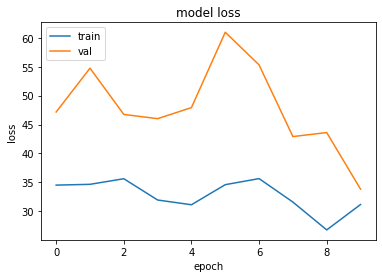

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
paths = ['/content/data/test_images/images/00'+ str(i) + '.jpg' for i in range(5000,10000)]
paths.append('/content/data/test_images/images/010000.jpg')

names = ['00'+ str(i) + '.jpg' for i in range(5000,10000)]
names.append('010000.jpg')

In [ ]:
test_df = pd.DataFrame({'path' : paths, 'filename': names} )

In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_set = train_generator.flow_from_dataframe(
    dataframe=test_df,
    target_size=(512, 512),
    x_col='path',
    y_col=None,
    class_mode=None,
    color_mode='rgb',
    shuffle=False
)

Found 5001 validated image filenames.


In [ ]:
y_pred = cnn.predict(test_set)

In [ ]:
values = list(np.squeeze(y_pred))

In [ ]:
test_df['xRot'] = values

In [ ]:
test_df.head()
test_df = test_df.drop(columns=['path'])

In [ ]:
test_df.head()

,filename,xRot
0,005000.jpg,347.538391
1,005001.jpg,248.972687
2,005002.jpg,287.752808
3,005003.jpg,108.392136
4,005004.jpg,1.331411


In [ ]:
test_df.to_csv("submission.csv", index=False)